___
# Logistic Regression

Example/template of running a Logistic regression 
___

In [1]:
## remove this, this is for my personal pc setup
import sys; import os; sys.path.append(os.path.expanduser('~/DropBox/my/projects/T/'))

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas   as pd
import operator as op

import numpy             as np
import seaborn           as sns
from datetime import datetime

import pyscope
from pyscope import read_ss

from IPython.display import IFrame

from T import * # want T to be accessible


%load_ext autoreload
%autoreload

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data

Setting up test data to look at

In [3]:
a = T(np.random.normal(0, size=(1000,1)), columns=["values"])
a['target'] = 1
b = T(np.random.normal(5, size=(1000,1)), columns=["values"])
b['target'] = 0

data = pd.concat([a, b])

data.head()

,values,target
0,-0.490644,1
1,1.087871,1
2,-0.631573,1
3,-0.471770,1
4,1.769046,1


In [4]:
X0 = data.drop(columns="target")
y = T(data).select("target")

display(X0.head(), y.head())

,values
0,-0.490644
1,1.087871
2,-0.631573
3,-0.471770
4,1.769046


,target
0,1
1,1
2,1
3,1
4,1


## Scale Features

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(X0)

## Search for best C value

In [6]:
## Search for best C value
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# Set values of the grid search
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 30000, 60000, 90000]
C_grid = {'C': C_values}
# Set the amount of folds for the cross-validation
n_folds = 5
# Do a model fit over a grid of C hyperparameters
logReg = LogisticRegression(random_state=42, solver='liblinear') # Stochastic Average Gradient
grid_logReg = GridSearchCV(logReg, C_grid, cv=n_folds, refit=True, n_jobs=-1)
grid_logReg.fit(X,y.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 30000, 60000, 90000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

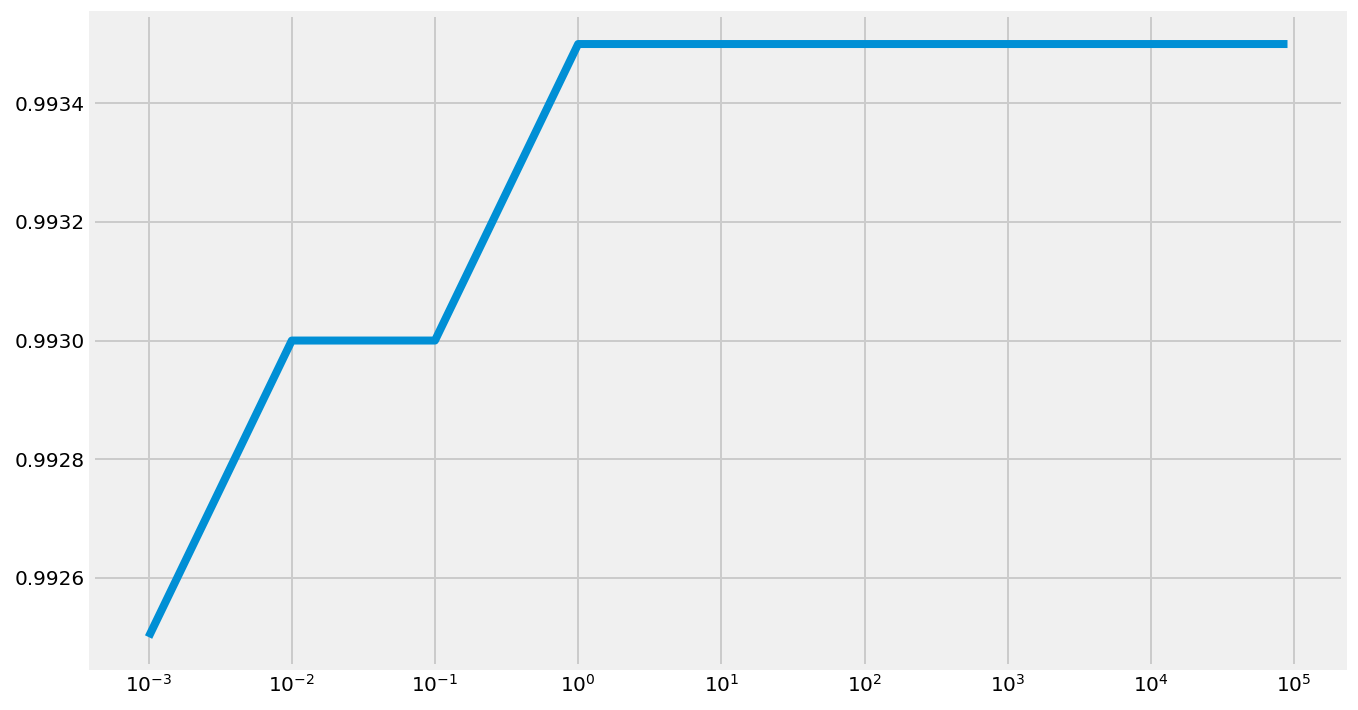

In [7]:
# Visualize maximum accuracy
plt.figure().set_size_inches(10, 6)
fg2 = plt.semilogx(C_values, grid_logReg.cv_results_['mean_test_score'])
plt.show()

In [8]:
grid_logReg.cv_results_['mean_test_score']

array([0.9925, 0.993 , 0.993 , 0.9935, 0.9935, 0.9935, 0.9935, 0.9935,
       0.9935, 0.9935])

## Feature Selection

in this data set there is only 1 feature (test data), so does not makes sense running the code, but here is how to do it.

In [9]:
# feature selection
#from sklearn.feature_selection import RFE
#log_clf = LogisticRegression(penalty='l2', solver='sag')
#rfe = RFE(log_clf)
#rfe.fit(X,y.values.ravel())

In [10]:
#print(rfe.support_)
#print(rfe.ranking_)
#print(X0[X0.columns[rfe.support_]].columns)

In [11]:
# Filter data sets based on feature selection
#X2 = X[X.columns[rfe.support_]]
#X = X2
#X = X[:, rfe.support_]

## Checking that Features are Significant

In [33]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2(xname=X0.columns))

Optimization terminated successfully.
         Current function value: 0.019581
         Iterations 12
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.972  
Dependent Variable: target           AIC:              80.3242
Date:               2019-05-16 09:07 BIC:              85.9251
No. Observations:   2000             Log-Likelihood:   -39.162
Df Model:           0                LL-Null:          -1386.3
Df Residuals:       1999             LLR p-value:      nan    
Converged:          1.0000           Scale:            1.0000 
No. Iterations:     12.0000                                   
---------------------------------------------------------------
          Coef.    Std.Err.     z     P>|z|    [0.025    0.975]
---------------------------------------------------------------
values   -12.2601    1.4870  -8.2451  0.0000  -15.1745  -9.3457



## Split Train & Test 

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=0.30, 
                                                    random_state=101)

In [15]:
X_train

array([[-0.46911095],
       [-0.35705234],
       [ 0.79155363],
       ...,
       [ 0.69778916],
       [ 1.54159671],
       [-0.87260482]])

## Training & Predicting

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(X_train,y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
coeff_df = pd.DataFrame(logmodel.coef_[0],X0.columns,columns=['Coefficient'])
T(coeff_df).sort("Coefficient", ascending=False)

,Coefficient
values,-6.918707


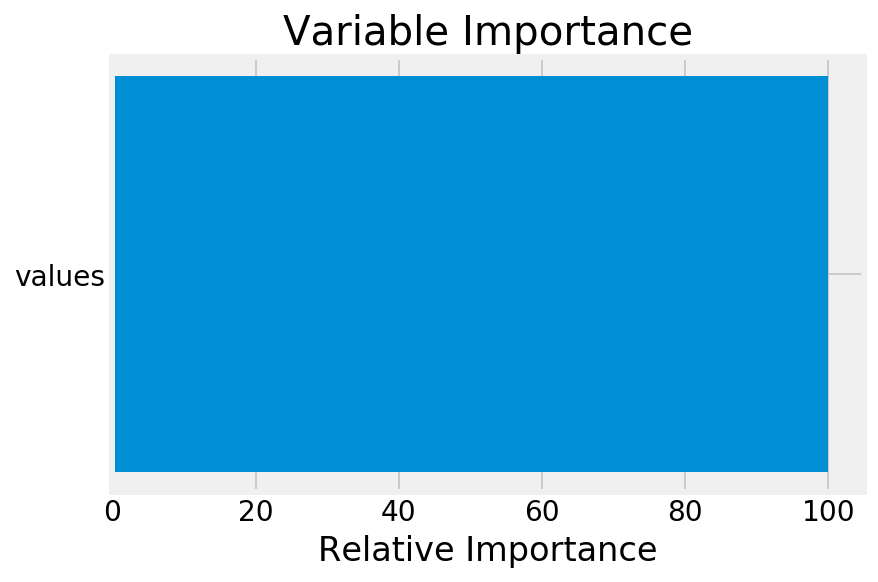

In [19]:
# #############################################################################
# Plot feature importance
feature_importance = logmodel.coef_[0]
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
plt.rcParams['font.size'] = 14
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X0.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Evaluation

In [20]:
predictions = logmodel.predict(X_test)

In [21]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confm = confusion_matrix(y_test,predictions)

Text(0.5, 257.44, 'Predicted label')

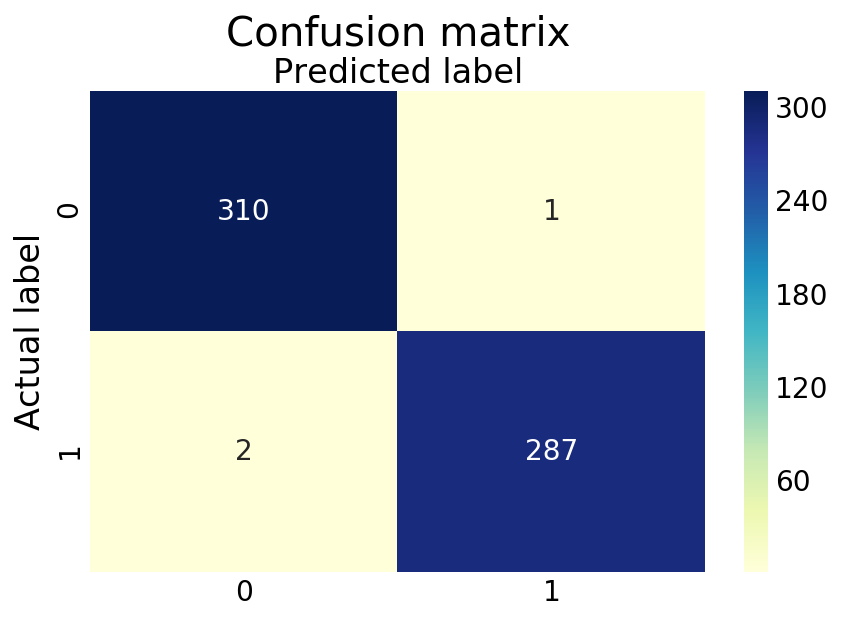

In [22]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [23]:
from sklearn.metrics import classification_report

In [24]:
IFrame('https://www.researchgate.net/profile/A_Prugel-Bennett/publication/312203449/figure/tbl1/AS:613952941735973@1523389196941/Classification-performance-measurement.png', 760, 315)


In [25]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       311
           1       1.00      0.99      0.99       289

   micro avg       0.99      0.99      0.99       600
   macro avg       1.00      0.99      0.99       600
weighted avg       1.00      0.99      0.99       600



In [26]:
from IPython.display import IFrame

IFrame('https://cdn-images-1.medium.com/max/1600/1*CPnO_bcdbE8FXTejQiV2dg.png', 760, 315)

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_test,predictions)

array([[310,   1],
       [  2, 287]], dtype=int64)

## Roc

In [29]:
y_pred_proba = logmodel.predict_proba(X_test)[::,1]


In [30]:
#convert into binary values
#for i in range(0,y_pred_proba.size):
#    if y_pred_proba[i]>=.5:       # setting threshold to .5
#       y_pred_proba[i]=1
#    else:  
#       y_pred_proba[i]=0

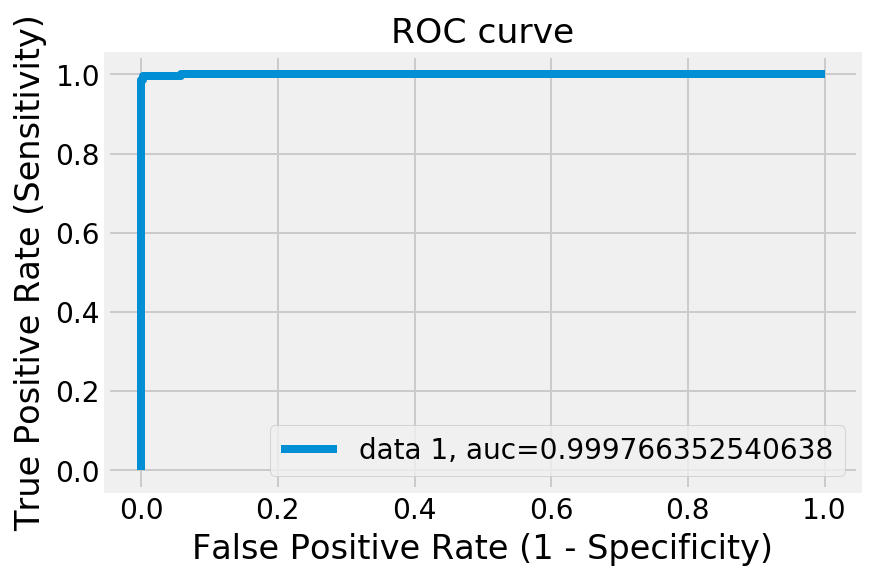

In [31]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

## Interpretation

“Interpreting the Impact Size of Logistic Regression Coefficients” by Ying Ma https://link.medium.com/N422oFou0V

https://medium.com/ro-data-team-blog/interpret-the-impact-size-with-logistic-regression-coefficients-5eec21baaac8

In [32]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(logmodel, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X0.columns.values)

Weight,Feature
0.4847 ± 0.0639,values
